# **kaggle.json**

In [3]:
from google.colab import files
files.upload()  # Upload new kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Found existing ~/.kaggle/kaggle.json — skipping upload.
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

=== Data preview ===


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,...,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19,1
1,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12,0
2,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00,0
3,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50,0
4,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89,0



=== Results summary ===
Anomaly summary: 500 anomalies detected (indices sample: [0, 32, 44, 45, 84, 112, 161, 174, 224, 251, 299, 315, 318, 327, 335, 343, 396, 434, 438, 445])

AI Suggestions (stub):
 Sample rows: [{'time': 41505.0, 'v1': -16.5265065691231, 'v2': 8.58497179585822, 'v3': -18.6498531851945, 'v4': 9.50559351508723, 'v5': -13.7938185270957, 'v6': -0.27921964604207, 'v7': -16.701694296045, 'v8': 7.51734390370987, 'v9': -8.50705863675898, 'v10': -14.1101844415457, 'v11': 5.29923634963938, 'v12': -10.8340064814734, 'v13': 1.67112025332681, 'v14': -9.37385858364976, 'v15': 0.360805641631617, 'v16': -9.89924654080666, 'v17': -19.2362923697613, 'v18': -8.39855199494575, 'v19': 3.10173536885404, 'v20': -1.51492343527852, 'v21': 1.19073869481428, 'v22': -1.12767000902061, 'v23': -2.3585787697881, 'v24': 0.673461328987237, 'v25': -1.4136996745882, 'v26': -0.46276236139933, 'v27': -2.01857524875161, 'v28': -1.04280416970881, 'amount': 364.19, 'class': 1.0}, {'time': 44261.0, 'v1':

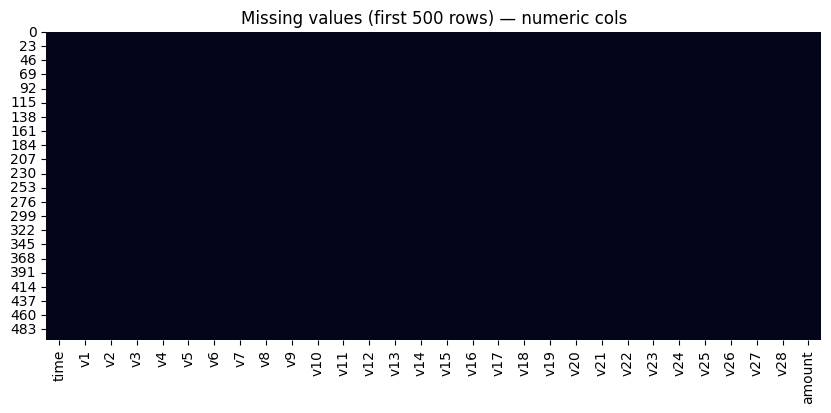


--- error_scatter ---


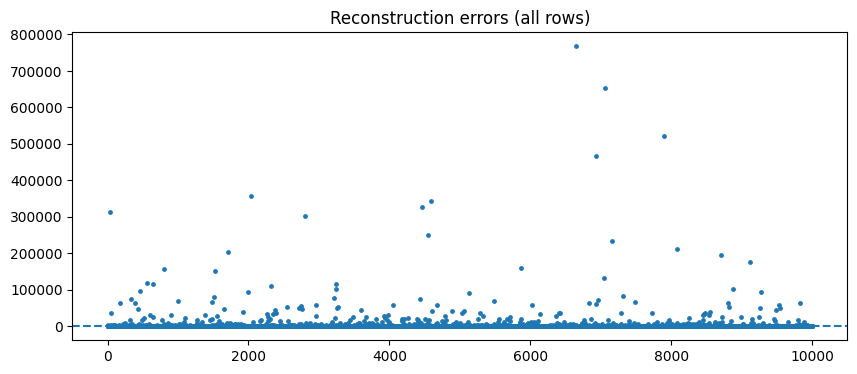


--- boxplot ---


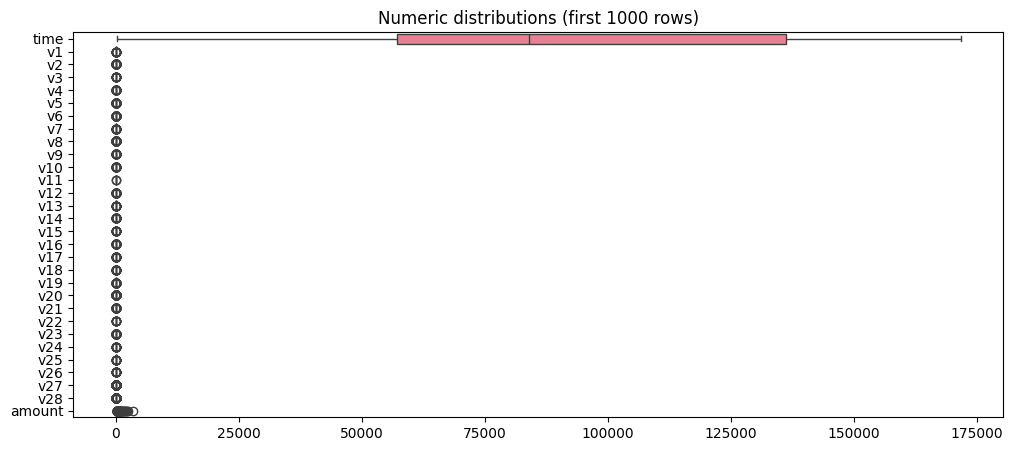

In [2]:
# ==============================
# Full updated Colab-ready script
# - Uses kaggle.json auth (upload if needed)
# - Fast, safe imputation (SimpleImputer by default)
# - Lightweight autoencoder optimized for Colab Free GPU
# - Helpful logs & inline outputs
# ==============================

# Install deps (Colab)
!pip install -q kaggle pandas numpy requests python-dotenv scikit-learn torch matplotlib seaborn datasets joblib

# Upload kaggle.json if needed (safe: will skip if ~/.kaggle/kaggle.json exists)
from google.colab import files
import os
if not os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")):
    print("Please upload your kaggle.json (Account > API > Create New Token).")
    uploaded = files.upload()  # upload kaggle.json
    for fn in uploaded.keys():
        os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
        os.rename(fn, os.path.expanduser("~/.kaggle/kaggle.json"))
        os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
    print("kaggle.json saved to ~/.kaggle/kaggle.json")
else:
    print("Found existing ~/.kaggle/kaggle.json — skipping upload.")

# ==============================
# Imports & setup
# ==============================
import time
import logging
import io
import base64

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import joblib

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from kaggle.api.kaggle_api_extended import KaggleApi
from IPython.display import Image, display

# Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger("colab-pipeline")

# ==============================
# Configuration — tune if needed
# ==============================
SUBSAMPLE_SIZE = 10000            # default subsample (10k rows) — change lower for faster runs
ARTIFICIAL_MISSING_PCT = 0.05     # 5% artificial missingness
USE_ITERATIVE_IMPUTER = False     # False -> use SimpleImputer (fast); True -> lightweight IterativeImputer
ITERATIVE_RF_ESTIMATORS = 30      # if using iterative imputer, number of trees
ITERATIVE_MAX_ITER = 5            # iterative imputer max_iter
AE_EPOCHS = 12                    # autoencoder epochs (small)
AE_BATCH_SIZE = 256               # batch size for training
AE_HIDDEN = (32, 16)              # encoder sizes
RANDOM_SEED = 42

# External keys (you can set to None or replace)
GEMINI_API_KEY = None
SERPAPI_KEY = None
GEMINI_URL = "https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash-latest:generateContent"

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# ==============================
# Helper functions
# ==============================
def authenticate_kaggle():
    try:
        api = KaggleApi()
        api.authenticate()
        logger.info("✅ Kaggle authentication successful")
        return api
    except Exception as e:
        logger.error(f"❌ Kaggle authentication failed: {e}")
        raise

def download_dataset(api, dataset="mlg-ulb/creditcardfraud", file_name="creditcard.csv"):
    logger.info(f"Downloading dataset {dataset} ...")
    t0 = time.time()
    api.dataset_download_files(dataset, path="./", unzip=True)
    elapsed = time.time() - t0
    logger.info(f"Dataset downloaded and unzipped in {elapsed:.1f}s")
    if not os.path.exists(file_name):
        raise FileNotFoundError(f"{file_name} not found after download")
    return file_name

def load_and_subsample(file_name="creditcard.csv", subsample=SUBSAMPLE_SIZE):
    df = pd.read_csv(file_name)
    logger.info(f"Loaded CSV with shape: {df.shape}")
    if subsample and subsample < len(df):
        df = df.sample(n=subsample, random_state=RANDOM_SEED).reset_index(drop=True)
        logger.info(f"Subsampled to: {df.shape}")
    # Keep original column names for initial checks; normalization done later
    df.columns = df.columns.str.strip()
    return df

def introduce_artificial_missing_simple(df, pct=ARTIFICIAL_MISSING_PCT):
    """Introduce random missing values. pct is fraction of total cells (0..1)."""
    df2 = df.copy()
    n_total = df2.size
    n_missing = int(n_total * pct)
    logger.info(f"Introducing ~{n_missing} artificial missing values ({pct*100:.2f}%)")
    # choose random (row, col) pairs
    rows = np.random.randint(0, df2.shape[0], size=n_missing)
    cols = np.random.randint(0, df2.shape[1], size=n_missing)
    for r, c in zip(rows, cols):
        df2.iat[r, c] = np.nan
    logger.info(f"Missingness introduced; current missing count: {df2.isna().sum().sum()}")
    return df2

def impute_missing_values(df, use_iterative=USE_ITERATIVE_IMPUTER):
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    logger.info(f"Imputing numeric columns: {len(numeric_cols)} columns")
    t0 = time.time()
    if len(numeric_cols) == 0:
        logger.warning("No numeric columns found; skipping imputation")
        return df

    # Work on numeric subset and preserve non-numeric columns
    df_num = df[numeric_cols].copy()

    if not use_iterative:
        logger.info("Using SimpleImputer (median) for speed")
        imputer = SimpleImputer(strategy="median")
        df_num_imputed = pd.DataFrame(imputer.fit_transform(df_num), columns=df_num.columns)
        joblib.dump(imputer, "/content/simple_imputer.pkl")
    else:
        logger.info("Using IterativeImputer with lightweight RandomForest (slower)")
        estimator = RandomForestRegressor(
            n_estimators=ITERATIVE_RF_ESTIMATORS,
            max_depth=6,
            n_jobs=-1,
            random_state=RANDOM_SEED
        )
        imputer = IterativeImputer(estimator=estimator, max_iter=ITERATIVE_MAX_ITER, random_state=RANDOM_SEED, sample_posterior=False)
        df_num_imputed = pd.DataFrame(imputer.fit_transform(df_num), columns=df_num.columns)
        joblib.dump(imputer, "/content/iterative_imputer.pkl")

    df_imputed = df.copy()
    df_imputed[df_num_imputed.columns] = df_num_imputed
    logger.info(f"Imputation done in {time.time() - t0:.1f}s. Saved imputer to /content/*.pkl")
    return df_imputed

# Lightweight autoencoder optimized for GPU
class SmallAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden1=AE_HIDDEN[0], hidden2=AE_HIDDEN[1]):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden2, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, input_dim)
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

def detect_anomalies_autoencoder(df, class_col='class', epochs=AE_EPOCHS, batch_size=AE_BATCH_SIZE):
    # Note: expects df columns already normalized to lowercase (we do that before calling)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(class_col, errors='ignore')
    logger.info(f"Running autoencoder anomaly detection on {len(numeric_cols)} numeric features")
    X = df[numeric_cols].values.astype(np.float32)

    # Use only normal rows (Class == 0) for training if available, else use the whole dataset
    if class_col in df.columns:
        normal_mask = (df[class_col] == 0).values
        X_train = X[normal_mask]
        logger.info(f"Found class column; training autoencoder on normal samples: {X_train.shape[0]} rows")
    else:
        X_train = X
        logger.info("No class column found; training autoencoder on full data")

    # keep training set small enough
    max_train = min(8000, X_train.shape[0])
    if X_train.shape[0] > max_train:
        idx = np.random.choice(X_train.shape[0], max_train, replace=False)
        X_train = X_train[idx]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")

    model = SmallAutoencoder(input_dim=X.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    dataset = TensorDataset(torch.tensor(X_train))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    model.train()
    best_loss = float('inf')
    patience = 3
    no_improve = 0
    t0 = time.time()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch in loader:
            inputs = batch[0].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)
        epoch_loss /= len(loader.dataset)
        logger.info(f"Epoch {epoch+1}/{epochs} — train_loss: {epoch_loss:.6f}")
        # early stopping
        if epoch_loss + 1e-5 < best_loss:
            best_loss = epoch_loss
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                logger.info("Early stopping triggered.")
                break
    logger.info(f"Training finished in {time.time() - t0:.1f}s. Best loss: {best_loss:.6f}")

    # Save model
    model_path = "/content/autoencoder.pth"
    torch.save(model.state_dict(), model_path)
    logger.info(f"Autoencoder saved to {model_path}")

    # Compute reconstruction errors for all rows
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X).to(device)
        recon = model(X_tensor)
        errors = torch.mean((recon - X_tensor) ** 2, dim=1).cpu().numpy()

    # threshold at 95th percentile
    threshold = np.percentile(errors, 95)
    anomaly_indices = np.where(errors > threshold)[0].tolist()
    logger.info(f"Anomaly detection: threshold={threshold:.6g}, anomalies_found={len(anomaly_indices)}")

    return anomaly_indices, errors, threshold, numeric_cols.tolist()

def get_ai_suggestions_stub(sample_data, anomaly_info, instructions):
    # Placeholder: keep this safe and optional — real call requires valid GEMINI_API_KEY and usage policy compliance
    return f"Sample rows: {sample_data}\nAnomaly summary: {anomaly_info}\nInstructions: {instructions}"

def generate_visualizations(df, errors, threshold, numeric_cols):
    visuals = {}
    # Missing heatmap (downscale for speed)
    plt.figure(figsize=(10, 4))
    sns.heatmap(df[numeric_cols].isnull().iloc[:500], cbar=False)  # show only first 500 rows for speed
    plt.title("Missing values (first 500 rows) — numeric cols")
    buf = io.BytesIO(); plt.savefig(buf, format='png', bbox_inches='tight'); buf.seek(0)
    visuals['missing_heatmap'] = base64.b64encode(buf.read()).decode('utf-8'); plt.close()

    # Error scatter
    plt.figure(figsize=(10, 4))
    plt.scatter(range(len(errors)), errors, s=6)
    plt.axhline(threshold, ls='--')
    plt.title("Reconstruction errors (all rows)")
    buf = io.BytesIO(); plt.savefig(buf, format='png', bbox_inches='tight'); buf.seek(0)
    visuals['error_scatter'] = base64.b64encode(buf.read()).decode('utf-8'); plt.close()

    # Boxplot of numeric distributions (downsample to first 1000 rows)
    plt.figure(figsize=(12, 5))
    sample_for_box = df[numeric_cols].iloc[:1000]
    sns.boxplot(data=sample_for_box, orient='h')
    plt.title("Numeric distributions (first 1000 rows)")
    buf = io.BytesIO(); plt.savefig(buf, format='png', bbox_inches='tight'); buf.seek(0)
    visuals['boxplot'] = base64.b64encode(buf.read()).decode('utf-8'); plt.close()

    logger.info("Visualizations prepared")
    return visuals

# ==============================
# Main pipeline
# ==============================
def main_pipeline():
    api = authenticate_kaggle()
    csv_file = download_dataset(api)
    df = load_and_subsample(csv_file, subsample=SUBSAMPLE_SIZE)

    print("\n=== Data preview ===")
    display(df.head())
    logger.info(f"Data types:\n{df.dtypes.value_counts().to_string()}")

    # FIXED: pass pct=... (matches function signature)
    df_missing = introduce_artificial_missing_simple(df, pct=ARTIFICIAL_MISSING_PCT)

    # Basic cleaning & normalization of column names (for downstream code)
    df_missing = df_missing.copy()
    df_missing.columns = df_missing.columns.str.strip().str.lower().str.replace(' ', '_')
    df_missing = df_missing.apply(lambda col: pd.to_numeric(col, errors='coerce') if col.dtype == 'object' else col)

    # Impute
    df_imputed = impute_missing_values(df_missing, use_iterative=USE_ITERATIVE_IMPUTER)

    # Save cleaned CSV
    cleaned_path = "/content/cleaned_creditcard.csv"
    df_imputed.to_csv(cleaned_path, index=False)
    logger.info(f"Cleaned CSV saved to {cleaned_path}")

    # Anomaly detection using autoencoder (GPU if available)
    anomaly_indices, errors, threshold, numeric_cols = detect_anomalies_autoencoder(df_imputed, class_col='class', epochs=AE_EPOCHS, batch_size=AE_BATCH_SIZE)

    # Simple sample and AI suggestions (stub)
    sample_data = df_imputed.head(5).to_dict(orient='records')
    anomaly_info = f"{len(anomaly_indices)} anomalies detected (indices sample: {anomaly_indices[:20]})"
    suggestions = get_ai_suggestions_stub(sample_data, anomaly_info, "Detect fraud anomalies and suggest fixes for inconsistencies.")

    # Visuals
    visuals = generate_visualizations(df_imputed, errors, threshold, numeric_cols)

    # Display outputs
    print("\n=== Results summary ===")
    print("Anomaly summary:", anomaly_info)
    print("\nAI Suggestions (stub):\n", suggestions)

    # show images inline
    for k, b64 in visuals.items():
        print(f"\n--- {k} ---")
        display(Image(data=base64.b64decode(b64)))

    model_files = {
        "imputer": "/content/simple_imputer.pkl" if not USE_ITERATIVE_IMPUTER else "/content/iterative_imputer.pkl",
        "autoencoder": "/content/autoencoder.pth",
        "cleaned_csv": cleaned_path
    }
    logger.info(f"Model/files saved: {model_files}")

    # Optional: prepare downloads (commented out to avoid blocking)
    try:
        from google.colab import files as colab_files
        for f in model_files.values():
            if os.path.exists(f):
                logger.info(f"Found file: {f}")
                # to download automatically uncomment the next line:
                # colab_files.download(f)
    except Exception as e:
        logger.warning(f"Could not auto-download files (this is optional): {e}")

    return {
        "anomalies": anomaly_indices,
        "errors": errors,
        "threshold": threshold,
        "suggestions": suggestions,
        "saved_files": model_files
    }

# Run the pipeline
if __name__ == "__main__":
    results = main_pipeline()
    logger.info("Pipeline finished. Inspect 'results' variable for details.")


In [3]:
from google.colab import files
import os

# List of files to download
model_files = [
    "/content/simple_imputer.pkl" if not False else "/content/iterative_imputer.pkl",  # Matches USE_ITERATIVE_IMPUTER=False
    "/content/autoencoder.pth",
    "/content/cleaned_creditcard.csv"
]

# Download each file if it exists
for file_path in model_files:
    if os.path.exists(file_path):
        print(f"Downloading {file_path}...")
        files.download(file_path)
    else:
        print(f"File {file_path} not found. Ensure the pipeline ran successfully.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>